# Setup the environment

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

data = glob.glob('data/*.jpg')
images = np.array([np.array(Image.open(fname)) for fname in data])

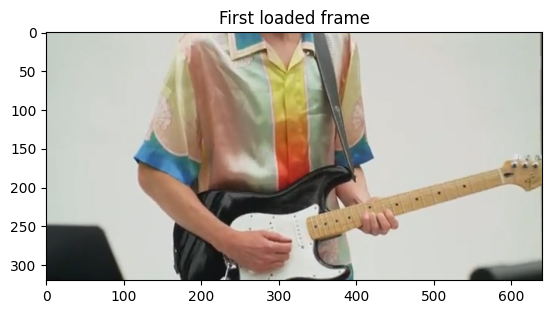

In [4]:
plt.title("First loaded frame")
plt.imshow(images[0])

# Pre-processing frames

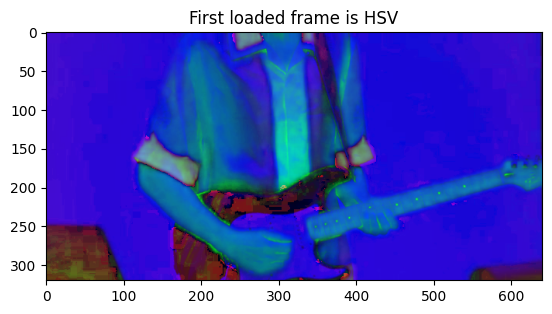

In [5]:
# Converting every frame from RGB to HSV
hsv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in images])

plt.title("First loaded frame is HSV")
plt.imshow(hsv[0])

# Computing motion vectors

In [6]:
OFFSET = 1
test = np.array([
[1, 2, 3], 
[4, 5, 6]])

px, py = 0, 0
min_y = max(0, py - OFFSET)
max_y = min(test.shape[0], py + OFFSET + 1)
min_x = max(0, px - OFFSET)
max_x = min(test.shape[1], px + OFFSET + 1)

print(test[min_y:max_y, min_x:max_x])

[[1 2]
 [4 5]]


In [153]:
OFFSET = 5

# returns best matching vector in mask traversal
def get_best_vector(hue, px_pos, frame, size):
    height, width = size
    py, px = px_pos
    
    # checking bounds
    min_y, min_x = max(0, py - OFFSET), max(0, px - OFFSET)
    max_y, max_x = min(size[0], py + OFFSET + 1), min(size[1], px + OFFSET + 1)

    neighbours = frame[min_y:max_y, min_x:max_x] # frame.shape = (320, 640, 3)
    matching = np.argwhere(neighbours[:, :, 0] == hue)
    if matching.size == 0:
        return 0, 0

    closest = np.argmin(np.linalg.norm(matching - px_pos, axis = 1))
    return matching[closest]

# returns all motion vectors between two frames
def get_frame_px_diff(frame1, frame2, size):
    frame_motion = np.empty(shape = (size[0], size[1], 2))

    for y in range(size[0] - 1):
        for x in range(size[1] - 1):
            hue = frame1[y, x, 0] # only saving hue from HSV
            frame_motion[y, x] = get_best_vector(hue, (y, x), frame2, size)

    return frame_motion

# returns motion vectors for each frame
def estimate_motion_px(hsv_frames):
    nb_frames = len(hsv_frames)
    height, width, _ = hsv_frames[0].shape
    motions = []
    for i in range(nb_frames - 1):
        if i > 3:
            return motions

        print("frame ", i)
        f1 = hsv_frames[i]
        f2 = hsv_frames[i + 1]
        frame_motion = get_frame_px_diff(f1, f2, (height, width))
        motions.append(frame_motion)

    return motions

In [154]:
# Compute pixel-wise motion vector for all frames
motions = estimate_motion_px(hsv)

frame  0
frame  1
frame  2
frame  3


### Displaying results

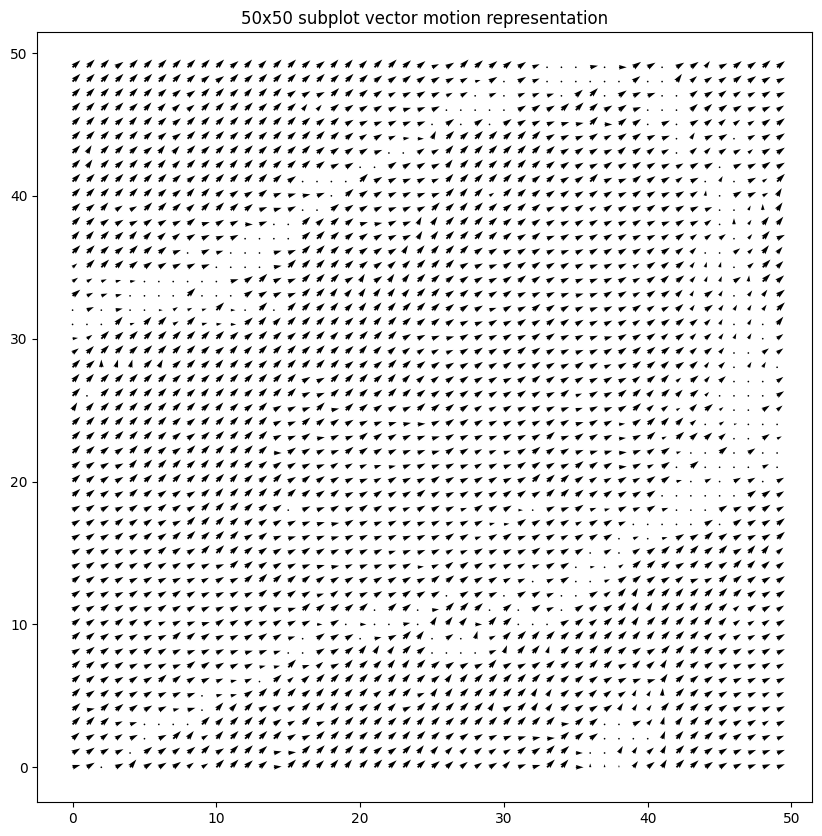

In [162]:
m = motions[0]
min_x, min_y = 150, 150
max_x, max_y = 200, 200

#print("m: ", m.shape)
#print("x_dir: ", m[min_y:max_y, min_x:max_x, 0])

plt.figure(figsize=(10, 10))
plt.quiver(m[min_y:max_y, min_x:max_x, 0], m[min_y:max_y, min_x:max_x, 1])
plt.title("50x50 subplot vector motion representation")
plt.show()